In [1]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import scipy

Populating the interactive namespace from numpy and matplotlib


In [2]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))

use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]



In [3]:
def collect_features(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    spectrogram = trim_zeros_frames(spectrogram)
    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    return mc

In [67]:
"PyTorch"
converted_target = '/home/pritish/CCPP/Voice_Converter_CycleGAN_Ran_Four_Days/Voice_Converter_CycleGAN/validation_output/converted_A/200001.wav'
reverse_target = '/home/pritish/CCPP/Voice_Converter_CycleGAN_Ran_Four_Days/Voice_Converter_CycleGAN/validation_output/converted_B/200001.wav'
source = '/home/pritish/CCPP/data/vcc2016_training/converted_sound_modified (2)/SF1/200001.wav'
target = '/home/pritish/CCPP/data/vcc2016_training/converted_sound_modified (2)/TF2/200001.wav'

In [4]:
# "Tensorflow"
converted_target = '/home/pritish/CCPP/Voice_Converter_CycleGAN_Ran_Four_Days/Voice_Converter_CycleGAN/validation_output/converted_A/200001.wav'
reverse_target = '/home/pritish/CCPP/Voice_Converter_CycleGAN_Ran_Four_Days/Voice_Converter_CycleGAN/validation_output/converted_B/200001.wav'
source = '/home/pritish/CCPP/Voice_Converter_CycleGAN_Ran_Four_Days/Voice_Converter_CycleGAN/data/evaluation_all/SF1/200001.wav'
target = '/home/pritish/CCPP/Voice_Converter_CycleGAN_Ran_Four_Days/Voice_Converter_CycleGAN/data/evaluation_all/TF2/200001.wav'

In [5]:
converted_target = collect_features(converted_target)
reverse_target = collect_features(reverse_target)
source = collect_features(source)
target = collect_features(target)

In [6]:
print(converted_target.shape, source.shape, target.shape, reverse_target.shape)

(780, 25) (778, 25) (829, 25) (831, 25)


In [24]:
def vis_difference(x, y_,z, which_dims=[0,2,3,6,8], T_max=None):
    y = x
    y_hat1 = y_
    y_hat2 = z
    pearson_coeff = np.zeros(24)
    root_mean_square = np.zeros(24)
    global_varaince_target = np.zeros(24)
    global_varaiance_converted = np.zeros(24)
    if T_max is not None and len(y) > T_max:
        x,y_,z = x[:T_max],y_[:T_max],z[:T_max]
    
    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(x[:,which_dim], "--", linewidth=1, label="SF1")
        plot(y_[:,which_dim], "-", linewidth=2, label="TF2")
        plot(z[:,which_dim], "-", linewidth=3, label="TF2->SF1")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")
        pearson_coeff[idx] = scipy.stats.pearsonr(x[:,which_dim], z[:,which_dim])[0]
        root_mean_square[idx] = np.sqrt(np.mean( (x[:,which_dim] - z[:,which_dim])**2 ) )
        global_varaince_target[idx] = np.std(x[:,which_dim])
        global_varaiance_converted[idx] = np.std(x[:, which_dims])
    return pearson_coeff, root_mean_square, global_varaince_target, global_varaiance_converted


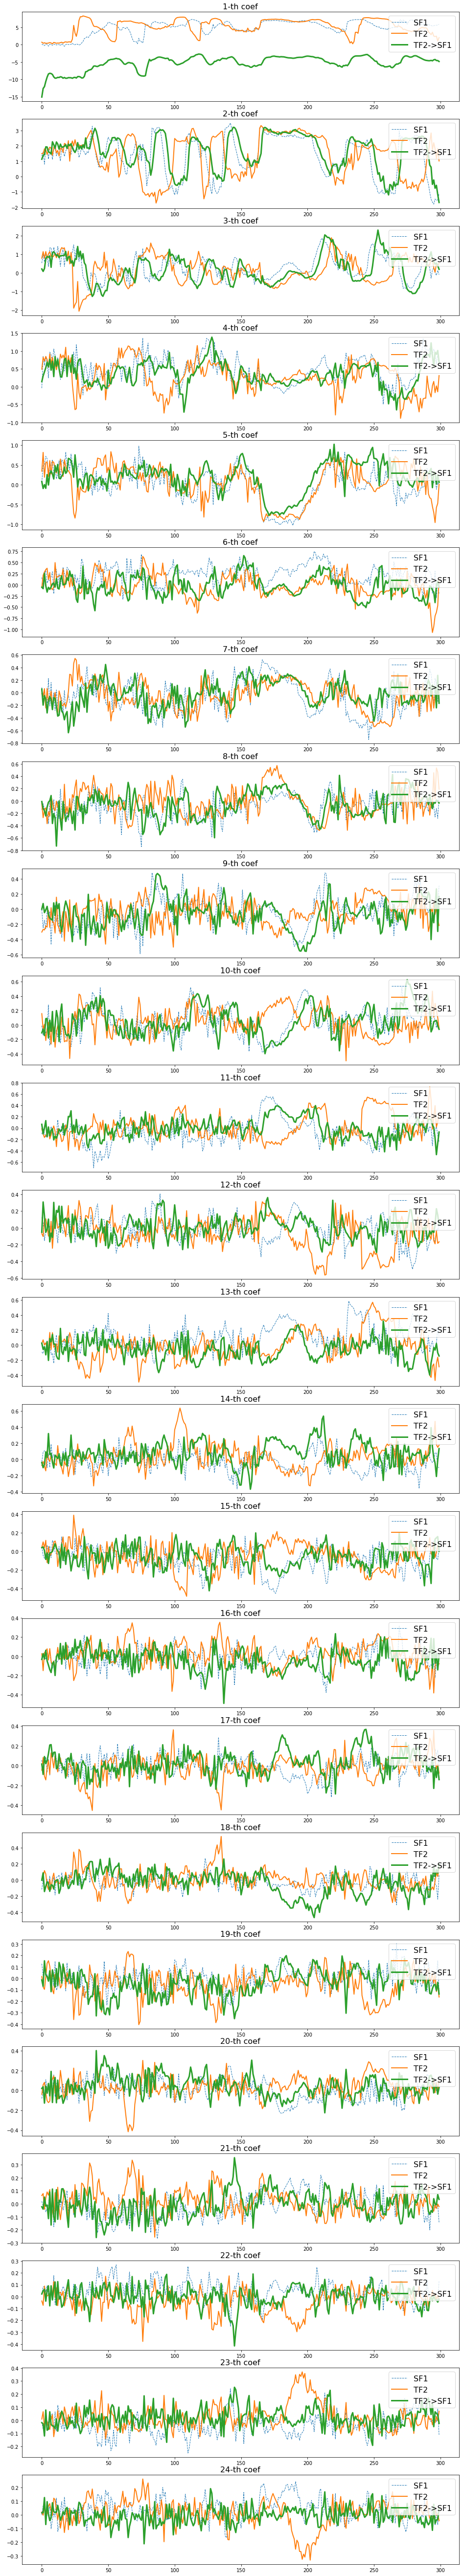

In [25]:
which_dims = np.arange(0, 24, step=1)
pearson, rms, var_target, var_converted = vis_difference(source, target, converted_target,T_max=300, which_dims=which_dims)

In [27]:
print("Pearson -> ", pearson)
print("RMS -> ", rms)
print("Global Variance target -> ", var_target)
print("Global Variance converted", var_converted)

Pearson ->  [ 0.89632098  0.7688002   0.65165232  0.60010351  0.70460525  0.33885363
  0.42191381  0.33544871  0.46841837  0.52879303  0.40849323  0.06180051
  0.02991422  0.06428896  0.13464132  0.10056368 -0.01092437  0.34409311
  0.34054201  0.30499111  0.23964809  0.10262211  0.15716678  0.00348944]
RMS ->  [10.13998887  0.87968296  0.57373123  0.34492662  0.35652661  0.36014475
  0.25564744  0.22400915  0.19968936  0.19040008  0.22104742  0.19059132
  0.25831787  0.20492703  0.15623779  0.14572428  0.15680773  0.1414391
  0.12512832  0.12688126  0.114542    0.12039466  0.11297918  0.10596949]
Global Variance target ->  [2.16115951 1.29075966 0.60820735 0.36716247 0.42979075 0.20680121
 0.26021634 0.17736161 0.1938705  0.19155912 0.21055474 0.14583643
 0.16332333 0.11625741 0.12068413 0.10067689 0.09705162 0.08444472
 0.0901221  0.10056171 0.08941978 0.08119891 0.08073333 0.0771559 ]
Global Variance converted [1.1339171 1.1339171 1.1339171 1.1339171 1.1339171 1.1339171 1.1339171
 1

In [31]:
def vis_difference(x, y_,z,which_dims=[0,2,3,6,8], T_max=None):
    y = x
    y_hat1 = y_
    y_hat2 = z
    pearson_coeff = np.zeros(24)
    root_mean_square = np.zeros(24)
    global_varaince_target = np.zeros(24)
    global_varaiance_converted = np.zeros(24)
    if T_max is not None and len(y) > T_max:
        x,y_,z = x[300:300+T_max],y_[300:300+T_max],z[300:300+T_max]

    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(x[:,which_dim], "--", linewidth=1, label="SF1")
        plot(y_[:,which_dim], "-", linewidth=2, label="TF2")
        plot(z[:,which_dim], "-", linewidth=3, label="SF1 -> TF2")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")
        pearson_coeff[idx] = scipy.stats.pearsonr(y_[:,which_dim], z[:,which_dim])[0]
        root_mean_square[idx] = np.sqrt(np.mean( (y_[:,which_dim] - z[:,which_dim])**2 ) )
        global_varaince_target[idx] = np.std(y_[:,which_dim])
        global_varaiance_converted[idx] = np.std(x[:, which_dims])
    return pearson_coeff, root_mean_square, global_varaince_target, global_varaiance_converted


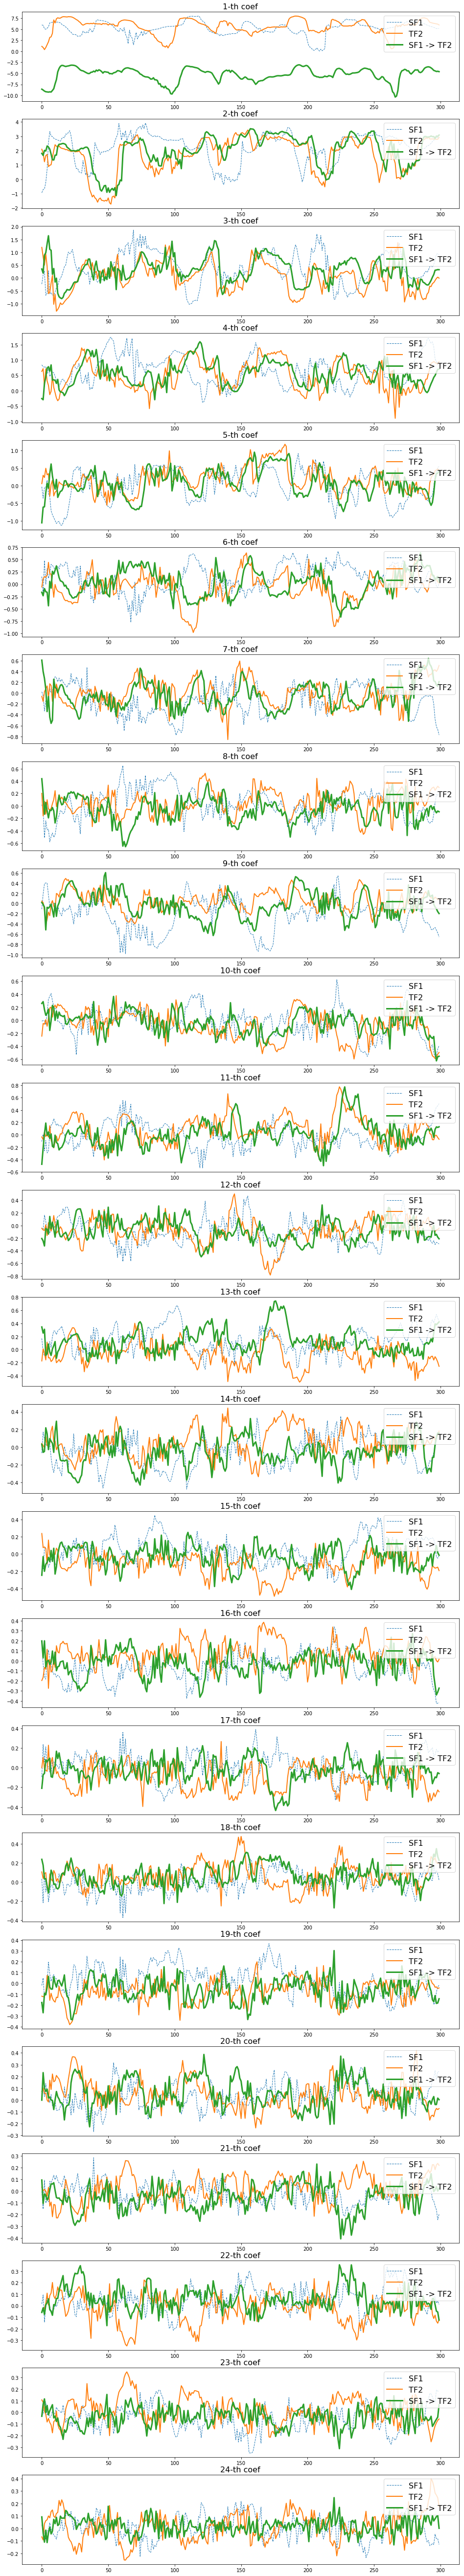

In [32]:
which_dims = np.arange(0, 24, step=1)
pearson, rms, var_target, var_converted = vis_difference(source, target, reverse_target,T_max=300, which_dims=which_dims)

In [33]:
print("Pearson -> ", pearson)
print("RMS -> ", rms)
print("Global Variance target -> ", var_target)
print("Global Variance converted", var_converted)

Pearson ->  [ 0.78821904  0.77728843  0.57052913  0.5512277   0.57694997  0.49928714
  0.46401209  0.25283908  0.3888789   0.37096047  0.48741948  0.22133606
  0.21270281  0.13680352  0.1078373  -0.12334485  0.14693339  0.16498545
  0.19248109  0.17336039 -0.07572542 -0.03231249  0.0737907   0.09049281]
RMS ->  [10.94691894  0.82383921  0.54374413  0.40637206  0.33626091  0.29182662
  0.25287625  0.25956311  0.25444127  0.21680446  0.22070217  0.22589334
  0.29261937  0.23441514  0.19455017  0.20952535  0.177276    0.15090738
  0.13183923  0.14957782  0.17373731  0.17881211  0.1442225   0.12371026]
Global Variance target ->  [1.6855992  1.21636233 0.5504853  0.45446044 0.34177779 0.2912046
 0.24116214 0.19454281 0.1846705  0.20972615 0.20381206 0.19433268
 0.17878102 0.15907395 0.13040242 0.12221537 0.12708919 0.12543739
 0.09995818 0.115039   0.10820745 0.11863867 0.11111048 0.11255771]
Global Variance converted [1.20281732 1.20281732 1.20281732 1.20281732 1.20281732 1.20281732
 1.202